In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

Ex. 13.1.1: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

There are a total of five different variables in the EL dataframe. There is the timestamp, which is measured in unix seconds. 

Then there are an identifier for two different people,u1 and u2. and the class that each of thoose two pupils have. 

Each row in this dataset is supposed to show a meeeting between two pupils as they have the same class, this is why there is an supposed edge between the two pupils.
    

In [2]:
el

,timestamp,u1,u2,class1,class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC
...,...,...,...,...,...
188503,1386345560,120,285,PC,PC
188504,1386345580,61,160,2BIO2,2BIO2
188505,1386345580,272,939,2BIO3,2BIO3
188506,1386345580,311,496,PC,PC


Then we turn it into datetime, and count the meetings during specific hours.

In [3]:

#converting timestamp into datatime
el['timestamp'] = pd.to_datetime(el['timestamp'], unit = 's')


# grouping, and counting for every hour
meetings = el.groupby(pd.Grouper(key = 'timestamp', freq = 'h')).size()
meetings


timestamp
2013-12-02 11:00:00    5556
2013-12-02 12:00:00    4259
2013-12-02 13:00:00    6617
2013-12-02 14:00:00    5715
2013-12-02 15:00:00    5972
                       ... 
2013-12-06 11:00:00    4106
2013-12-06 12:00:00    3247
2013-12-06 13:00:00    1785
2013-12-06 14:00:00    2026
2013-12-06 15:00:00    1352
Freq: H, Length: 101, dtype: int64

Ex. 13.1.2: Count the number of meetings for each edge and save this as a DataFrame called el_agg. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [4]:

el_agg = el.groupby([el.timestamp.dt.minute >5,el.u1,el.u2]).size().reset_index(name="meetings").drop(["timestamp"],axis=1)
el_agg = el_agg.merge(ind, right_index=True,left_on=["u1"]).rename(columns={"class":"u1_class","gender":"u1_gender"})
el_agg = el_agg.merge(ind, right_index=True,left_on=["u2"]).rename(columns={"class":"u2_class","gender":"u2_gender"}).reset_index().drop(["index"],axis=1)
el_agg.head(10)


,u1,u2,meetings,u1_class,u1_gender,u2_class,u2_gender
0,1,55,2,2BIO3,M,2BIO3,F
1,1,55,6,2BIO3,M,2BIO3,F
2,1,63,1,2BIO3,M,2BIO3,F
3,1,63,1,2BIO3,M,2BIO3,F
4,3,63,2,2BIO2,M,2BIO3,F
5,27,63,19,2BIO2,M,2BIO3,F
6,39,63,1,2BIO3,F,2BIO3,F
7,45,63,1,PC,F,2BIO3,F
8,46,63,1,2BIO2,F,2BIO3,F
9,61,63,1,2BIO2,F,2BIO3,F


Ex. 13.1.3: Answer question in the function fraction_triangles below. Explain how fraction_triangles is related to computing the clustering coefficient (using nx.average_clustering).

C:\Users\sakzo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


NameError: name 'binom' is not defined

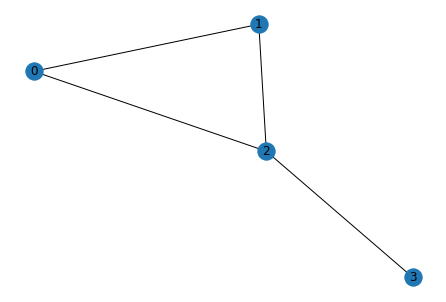

In [5]:
import networkx as nx 

A  = np.array(
    [[0, 1, 1, 0],
     [1, 0, 1, 0],
     [1, 1, 0, 1],
     [0, 0, 1, 0]]
)

G = nx.from_numpy_array(A)
nx.draw(G,with_labels=True)

def nth(A, n):
    A_ = A.copy()    
    for _ in range(1,n):
        A = A.dot(A_)
    return A

a_t = nth(A,3).diagonal().sum()/6
n = len(A[:,0])
p_t = binom(n, 3)

In [6]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2','meetings', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [7]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: 
    #Q.2: what does `A**3` do?
    #Q.3: what is diagonal of A_t?
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute?
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

Question 1.
the adjacency matrix which is symmetric and binary.
Each row in the matrix symbolize a node, and each digit symbolise if there is an edge or not between the node and another node.


Question 2.
 compute the number of paths between two nodes



question 3 .
 the number of actual paths of length 3, 



question 4 .
 the number of triangles including the person


Ex. 13.1.4: Apply the function fraction_triangles to el_agg and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.

In [8]:
from sklearn.utils import resample

In [9]:
import progressbar

In [10]:

def nodes(df):
    """
    compute a list containing node identities 
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    
    Returns:
    nodes_ (list): list of unique node identities sorted in ascending order.
    
    """
    
    nodes_ = sorted(df.u1.unique().tolist()+df.u2.unique().tolist())
    return nodes_

def mean_class_triangles(df):
    """
    compute the triangle fraction within each class and returns the mean.
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    
    Returns:
    np.mean(frac_triang_class) (float): mean within class triangles
    
    """
    #initialize storage
    frac_triang_class = np.empty(len(df.u1_class)) 
    
    for i,c in enumerate(df.u1_class):
        # removing edges that go between classes
        sample_class = el_agg.loc[(el_agg["u1_class"]==c) & (el_agg["u1_class"]==el_agg["u2_class"])]
        class_nodes = nodes(sample_class) #computing class nodes 
        frac_triang_class[i] = fraction_triangles(sample_class,class_nodes)
    return np.mean(frac_triang_class)

def bootstrap(df,n_iter,bootstraps):
    """
    compute the bootstrapped std. error of the mean
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    n_iter (int): Number of iterations
    bootstraps (int): number of samples 
    
    Returns:
    np.std(mean) (float): The bootstrapped std. error of the mean
    """
    #initializing storage
    mean = np.empty(n_iter)
    
    for i,_ in enumerate(progressbar.progressbar(range(n_iter))):
        sample_df = resample(df,n_samples=bootstraps,stratify=df) #resampling DataFrame. Data is stratified.
        mean[i] = mean_class_triangles(sample_df)
    return np.std(mean)

In [11]:
# full network

nodes_full = nodes(el_agg)
frac_triang_full = fraction_triangles(el_agg,nodes_full)
print(f'The fraction of triangles in the full network is: {frac_triang_full}')


The fraction of triangles in the full network is: 0.005962397231915774


We see here that the mean of the full network is 0.00596 which is then compared with the in class mean below.

In [12]:
# within class network

frac_triang_class = mean_class_triangles(el_agg)
print(f'The mean fraction of triangles within classes is: {frac_triang_class}')

The mean fraction of triangles within classes is: 0.39643753319148023


The in class mean is at 0.3964 which is quite alot higher than the mean of the full network. This makes perfect sense as we would intuitively think that people woul have more and longer meetings with people from their own class than on average with everyone else.

In [13]:
#bootstrapping

n_iter = 1000
bootstraps = 20

bootstrap_std = bootstrap(el_agg,n_iter,bootstraps)
print(f'The bootstrapped std. error of the mean is: {bootstrap_std:.10f}')

100% (1000 of 1000) |####################| Elapsed Time: 0:06:03 Time:  0:06:03


The bootstrapped std. error of the mean is: 0.0168366352


We get a std error of the mean of 0.0164 which is not that high compared to the mean of 0.3964

Ex. 13.1.5: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [14]:

def hom_index(df):
    df["gender_sorting"] = df.u1_gender==df.u2_gender
    df["gender_sorting"] = df["gender_sorting"].astype(int)
    H = np.sum(df.gender_sorting==1)/np.shape(df)[0]
    return H

def baseline_hom(df):
    k = ind.gender.value_counts()
    same_gender_edges = (k[0]*(k[0]-1)+k[1]*(k[1]-1))/2
    total_edges = ((k[0]+k[1])*((k[0]+k[1])-1))/2
    B = same_gender_edges / total_edges
    return B

def inbreeding_hom(df):
    H = hom_index(df)
    B = baseline_hom(df)
    IH = (H-B)/(1-B)
    return IH

In [15]:
import warnings
warnings.filterwarnings('ignore')


In [16]:
def mean_class_hom(df):
    class_inbreed = np.empty(len(df.u1_class))

    for i,c in enumerate(df.u1_class):
        # removing edges that go between classes
        sample_class = el_agg.loc[(el_agg["u1_class"]==c) & (el_agg["u1_class"]==el_agg["u2_class"])]
        class_inbreed[i] = inbreeding_hom(sample_class)
    return np.mean(class_inbreed)

def bootstrap_hom(df,n_iter,bootstraps):
    mean_hom = np.empty(n_iter)
    
    for i,_ in enumerate(progressbar.progressbar(range(n_iter))):
        sample_df = resample(df,n_samples=bootstraps) #resampling DataFrame. Data is stratified.
        mean_hom[i] = mean_class_hom(sample_df)>=0
    return np.std(mean_hom)

In [17]:
# inbreeding homophily in class
mean_hom = mean_class_hom(el_agg)
print(f'The mean of inbreeding homophily within classes is: {mean_hom}')


The mean of inbreeding homophily within classes is: 0.22220007609769651


In [18]:
#Bootstrapping
n_iter = 1000
bootstraps = 20

hom_bootstrap_std = bootstrap_hom(el_agg,n_iter,bootstraps)
print(f'The bootstrapped std. error of the mean is: {hom_bootstrap_std}')

100% (1000 of 1000) |####################| Elapsed Time: 0:01:41 Time:  0:01:41


The bootstrapped std. error of the mean is: 0.0
